<a id="title_ID"></a>
# Example satellite trail detection in WFC/ACS data with findsat_mrt

This notebook provides examples of how to find satellite trails in ACS/WFC data. The tools presented here should be applicable to any imaging data.

### Table of Contents

[Introduction](#intro_ID) <br>
[Imports and Setup](#imports) <br>
[Example 1: Find trails in an FLC image](#example1) <br>
[Example 2: Find trails in a DRC image](#example2) <br>
[Example 3: Example quick run on a DRC image](#example3)<br>
[About this Notebook](#about_ID) 

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as diffraction spikes () and glint ().  

A full description of the algorithm is provided in [insert ISR]. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard Radon Transform (link) except that it calculates the median of the data along all possible paths through an image, rather than the sum. This alteration makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence. These parameters, especially with maximum allowed trail width, are tuned for ACS/WFC data and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created.

The routine provides numerous ways of visualizing the results, as will be demonstrated below.

<a id="imports"></a>
## Imports and Setup

Set your working directory and import the needed packages with the following

In [1]:
#check your own working directory
import os
print('Current working directory is {}'.format(os.getcwd()))

#update as needed with
#os.chdir('/Users/dstark/acs_work/satellite_trails/findsat_mrt/')


Current working directory is /Users/dstark/acs_work/acs-notebook/acs_findsat_mrt


In [2]:
#import modules and setup
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import bitmask
import numpy as np
import ccdproc
from astroquery.mast import Observations
from acstools.findsat_mrt import trailfinder

#These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

Next, download the example data from <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">here</a> and put it in your working directory.

<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels and make the image a bit small (to speed up the calculation of the MRT)

In [3]:
#Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    dq=h[ext+2].data #data quality bitmasks
    
    header = h[0].header #primary header
    image_header = h[1].header #image header


In [4]:
#make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially mask trails
mask = bitmask.bitfield_to_boolean_mask(dq,ignore_flags=[4096,8192,16384])
image[mask == True]=np.nan

#Subtract the background from the image. Here we just do a simple median
image = image-np.nanmedian(image)

In [5]:
#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 4,func=np.nansum)

We now set up trailfinder inside findsat_mrt. Many of the parameters in the call below are optional (set to their current values by default) but we show them to illustrate the setup. I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties.

In [6]:
#Now we can set up findsat_mrt
s=trailfinder(image=image_rebin,
            header=header,
            image_header=image_header,
            save_image_header_keys = ['ROOTNAME','CCDCHIP','CRPIX1','CRPIX2','CRVAL1','CRVAL2','ORIENTAT','RA_APER','DEC_APER','PA_APER'],
            threads=8,
            plot=False,
            threshold=5,
            max_width=75,
            check_persistence=True,
            min_persistence=0.5,
            output_root='test')

Before we actually run anything, let's plot the image. You should see two satellite trails in this example.

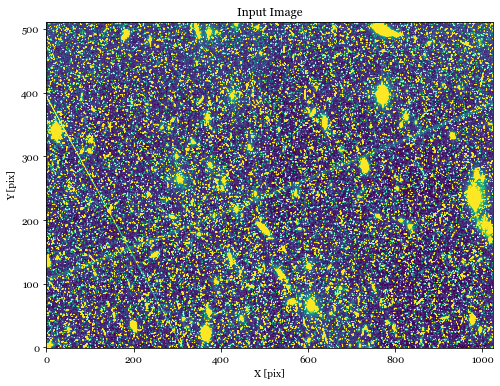

In [7]:
s.plot_image()

#We e can see the satellite trail crossing the left side of the image

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of threads being used

In [8]:
#let's calculate the Median Radon Transform (MRT) for this image. This can take a while depending on your image 
#size and number of threads
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/dstark/miniconda3/envs/satellite_trails/lib/

(360, 2, 1449)


/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/findsat_mrt.py:252: RuntimeWarning: divide by zero encountered in true_divide
  self.mrt_err = 1.25*self._image_stddev/np.sqrt(self.length) #error on median ~ 1.25x error on mean


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

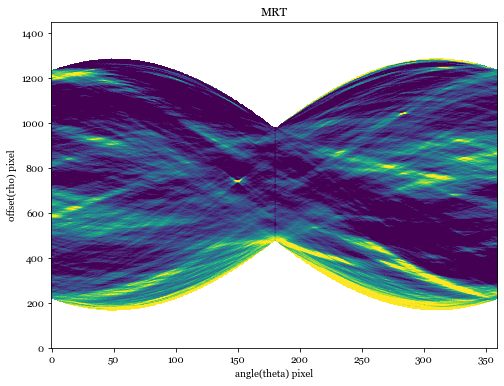

In [9]:
s.plot_mrt()

We next run the source finder on the MRT. Depending on the settings. This can pick up a lot more than the actual trails. There are additional steps we'll take later to filter these false detections out.

In [10]:
s.find_mrt_sources()
s.source_list

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:3 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:7 sources found
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:24 sources found


id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag,theta,rho,endpoints,status
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,"float64[2,2]",int64
1,2.556921852638252,585.7124524421566,11.208145112147267,0.8795779421924734,89.80076262921622,11.818336083671394,906.817181937332,-7.393799350840318,1.278460926319126,-138.28754755784337,367.4760116858094 .. 511.0,0
2,149.46243376533872,738.6182271814416,9.339687150006457,0.7056270720611201,85.67469810530051,31.50620683625238,1159.3522038963445,-7.66053847984031,74.73121688266936,14.618227181441625,0.0 .. 379.97795270196525,0
3,282.7333422953691,1037.6218786390145,7.811912038038552,0.8221626070008908,69.76825298371844,121.8596644516795,897.9915439341946,-7.3831806177261425,141.36667114768454,313.62187863901454,-0.0 .. 0.0,0
4,357.0279517793017,241.14516765086637,11.945708773909256,0.9227416251525582,89.3436189323143,11.89948485834648,753.7146128960259,-7.1930173384600495,178.51397588965085,-482.85483234913363,987.8891427894395 .. 0.0,0
5,325.26899850459347,265.687527881605,11.80021494714486,0.76454693301914,95.64644914102034,25.33490979686316,1827.0660681341817,-8.154385630159283,162.63449925229673,-458.312472118395,911.7999523191393 .. 155.41003465452695,0
9,357.10786934958185,860.7569375528348,11.782333052929335,0.9204633111250182,89.41537050381578,10.636501268810429,694.9201978803841,-7.104837336618828,178.55393467479092,136.75693755283476,368.2496625574116 .. 0.0,0
13,310.3296205566686,296.8507733104668,12.135467897793857,0.7778084159740938,94.86979094218843,17.887041312650094,1856.071756116492,-8.171486905303873,155.1648102783343,-427.1492266895332,863.9295870634014 .. 167.2946351876667,0
15,236.9390264371301,379.5387924008449,11.706150594024434,0.778809778016174,98.99645978778047,12.705735072369007,896.2565251998369,-7.38108082642595,118.46951321856506,-344.4612075991551,762.9387254276179 .. 369.9773679446612,0
16,207.07172582840704,423.8899951799956,12.204965257662993,0.7729422121570554,95.82979561985644,16.51751981484534,1354.1802513188682,-7.82919118994029,103.53586291420352,-300.1100048200044,732.418606321484 .. 441.04518492257534,0


We can plot the MRT again and it will overlay the sources. There are a lot, but not all are what we want.

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

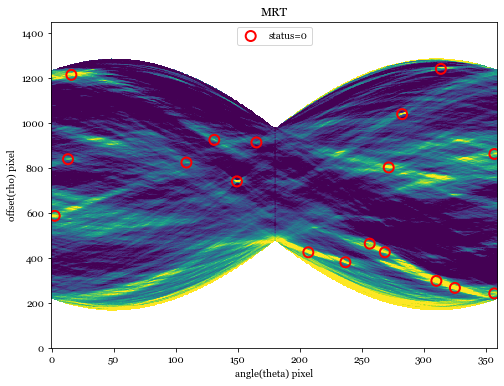

In [11]:
s.plot_mrt(show_sources=True)

We filter the sources further based on their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data. It's possible different defaults will be better for different imaging data.

In [12]:
s.filter_sources()
#some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
INFO:findsat_mrt:Min SNR : 5
INFO:findsat_mrt:Max Width: 75
INFO:findsat_mrt:Min Length: 25
INFO:findsat_mrt:Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 37.656043047368186
INFO:utils_findsat_mrt:baseline noise: 8.046853488802926
INFO:utils_findsat_mrt:snr of feature = 3.6795984417718053
INFO:utils_findsat_mrt:width of feature = 47.17828967584845
INFO:utils_findsat_mrt:amplitude of feature: 94.83667587274397
INFO:utils_findsat_mrt:baseline noise: 7.189818348315032
INFO:utils_findsat_mrt:snr of feature = 12.190413342636035
INFO:utils_findsat_mrt:width of feature = 12.902805804864784
INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
INFO:utils_findsat_mrt:Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 10
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWar

/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 567.7246356991848
INFO:utils_findsat_mrt:baseline noise: 12.732827847613358
INFO:utils_findsat_mrt:snr of feature = 43.58747440032334
INFO:utils_findsat_mrt:width of feature = 2.621875607624247
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 43.58747440032334, 2.621875607624247, 245.54889828121986
INFO:utils_findsat_mrt:Checking persistence, step 3 of 5
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 541.3906888667176
INFO:utils_findsat_mrt:baseline noise: 15.782889352410674
INFO:utils_findsat_mrt:snr of feature

/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
INFO:utils_findsat_mrt:amplitude of feature: 34.379365789921145
INFO:utils_findsat_mrt:baseline noise: 7.624307834304843
INFO:utils_findsat_mrt:snr of feature = 3.509178608349794
INFO:utils_findsat_mrt:width of feature = 177.6389472635409
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
INFO:utils_findsat_mrt:amplitude of feature: 78.45912467785791
INFO:utils_findsat_mrt:baseline noise: 6.559554268492634
INFO:utils_findsat_mrt:snr of feature = 10.96104513605733
INFO:utils_findsat_mrt:width of feature = 108.8209843138012
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/numpy/li

id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag,theta,rho,endpoints,status,mean flux,width,snr,persistence
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,"float64[2,2]",int64,float64,float64,float64,float64
1,2.556921852638252,585.7124524421566,11.208145112147267,0.8795779421924734,89.80076262921622,11.818336083671394,906.817181937332,-7.393799350840318,1.278460926319126,-138.28754755784337,367.4760116858094 .. 511.0,0,24.12035993770153,47.17828967584845,3.6795984417718053,0.0
2,149.46243376533872,738.6182271814416,9.339687150006457,0.7056270720611201,85.67469810530051,31.50620683625238,1159.3522038963445,-7.66053847984031,74.73121688266936,14.618227181441625,0.0 .. 379.97795270196525,2,85.07198506119805,12.902805804864784,12.190413342636035,1.0
3,282.7333422953691,1037.6218786390145,7.811912038038552,0.8221626070008908,69.76825298371844,121.8596644516795,897.9915439341946,-7.3831806177261425,141.36667114768454,313.62187863901454,-0.0 .. 0.0,2,433.64981506129465,4.006194751109547,50.51266311092556,1.0
4,357.0279517793017,241.14516765086637,11.945708773909256,0.9227416251525582,89.3436189323143,11.89948485834648,753.7146128960259,-7.1930173384600495,178.51397588965085,-482.85483234913363,987.8891427894395 .. 0.0,0,44.465379379504114,197.94015183916122,10.57818071700412,0.0
5,325.26899850459347,265.687527881605,11.80021494714486,0.76454693301914,95.64644914102034,25.33490979686316,1827.0660681341817,-8.154385630159283,162.63449925229673,-458.312472118395,911.7999523191393 .. 155.41003465452695,0,48.620455794374394,94.39493546033282,11.237235230729203,0.0
9,357.10786934958185,860.7569375528348,11.782333052929335,0.9204633111250182,89.41537050381578,10.636501268810429,694.9201978803841,-7.104837336618828,178.55393467479092,136.75693755283476,368.2496625574116 .. 0.0,0,15.515560231208504,92.94445069519278,2.3265610931181073,0.0
13,310.3296205566686,296.8507733104668,12.135467897793857,0.7778084159740938,94.86979094218843,17.887041312650094,1856.071756116492,-8.171486905303873,155.1648102783343,-427.1492266895332,863.9295870634014 .. 167.2946351876667,0,51.530863531896586,87.79607612449169,8.94381231697917,0.0
15,236.9390264371301,379.5387924008449,11.706150594024434,0.778809778016174,98.99645978778047,12.705735072369007,896.2565251998369,-7.38108082642595,118.46951321856506,-344.4612075991551,762.9387254276179 .. 369.9773679446612,0,31.833801563158268,19.69586653395507,4.2955162563570894,0.0
16,207.07172582840704,423.8899951799956,12.204965257662993,0.7729422121570554,95.82979561985644,16.51751981484534,1354.1802513188682,-7.82919118994029,103.53586291420352,-300.1100048200044,732.418606321484 .. 441.04518492257534,0,36.43275731714434,31.79392634851007,4.557144018556817,0.0


Several columns have been added to the source list that characterize the observed streak. Also, the status array has values of 0, 1, and 2 now (it just had 0 before). Status=2 are sources that passed all filtering stages (checks for SNR and width, then persistence). Status=1 are sources that passed the first filtering stage, but not the second. And status=0 are sources that did not pass the filtering steps.

The plot command will automatically overplot the different statuses

<AxesSubplot:title={'center':'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

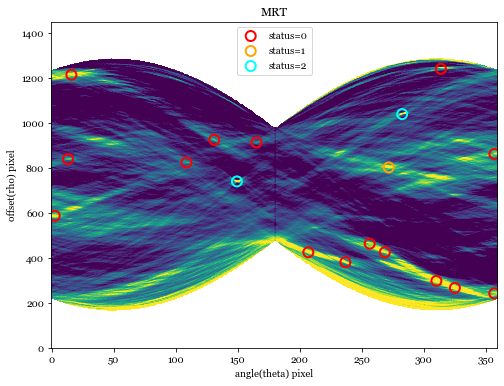

In [13]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the its ID number. We can also overlay the mask on top of the image to make sure it makes sense.

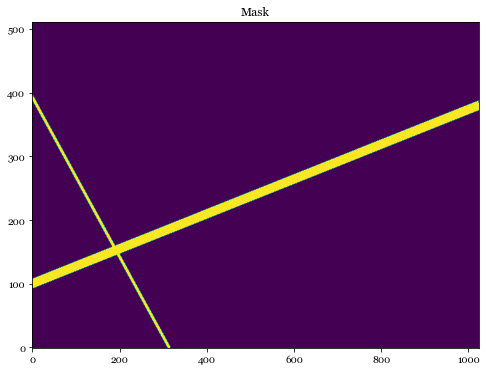

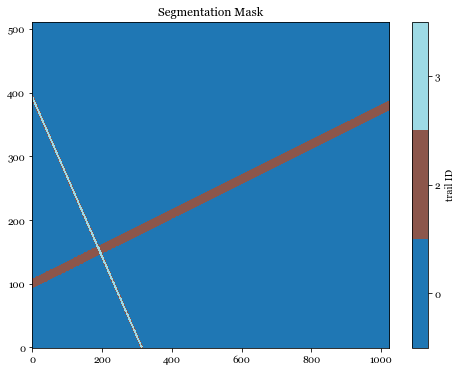

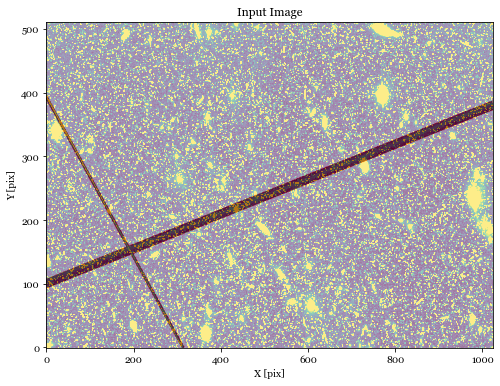

In [14]:
s.make_mask(plot=True)
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [15]:
os.getcwd()

'/Users/dstark/acs_work/acs-notebook/acs_findsat_mrt'

In [17]:
s.save_output(save_mask=True,save_mrt=True,save_diagnostic=True,save_catalog=True,output_dir='./',root = 'flc_test')

Keep in mind that this mask is applicable to the rebinned image. To convert it into a mask that can be applied to the original image, we need to resample it

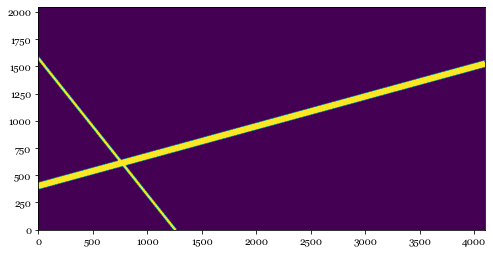

In [18]:
full_mask = ccdproc.block_replicate(s.mask, 4, conserve_sum=False)
fig,ax=plt.subplots()
ax.imshow(full_mask,origin='lower')

<a id="example2"></a>
## Example 2: Finding trails in a DRC image

Applying our code to a DRC image (that shows both chips together) can increase sensitivity by increasing the number of pixels over which we search for trails. The drc files also remove the distortion in the original flc files (though this does not appear to create signficant curvature to trails). 

There are no DQ arrays for the drc files, so we ignore the pre-processing steps that incorporated those.

In [ ]:
#Read in the image files and header information
image_file = 'example_data/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    wht = h[ext+1].data
    image = image*wht #wht is effective exposure time, so this turns it into counts
    variance = image #just assumimg very simplistic poisson stats for now
    
    header = h[0].header #primary header
    image_header = h[1].header #image header

In [ ]:
#Flag anything with wht == 0 as bad
image[wht == 0]=np.nan
variance[wht == 0] = np.nan

#Subtract the background from the image. Here we just do a simple median
median = np.nanmedian(image)
image = image-np.nanmedian(image)

In [ ]:
#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 4,func=np.nansum)

Setting up findsat_mrt is essentially the same as example 1 now. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [ ]:
#Now we can set up findsat_mrt
s2=trailfinder(image=image_rebin)

In [ ]:
#we can do a quick plot of our image to make sure things look ok
s2.plot_image()

In [ ]:
s2.run_mrt(threads=8)

In [ ]:
#let's plot the MRT
s2.plot_mrt()

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around x,y = 90,700 and x,y = 300,700. Now we'll see if we can pull them out.

In [ ]:
s2.find_mrt_sources()
s2.source_list

In [ ]:
print(s2.source_list)


In [ ]:
s2.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

In [ ]:
s2.filter_sources(plot=False)
s2.plot_mrt(show_sources=True)

Let's re-plot the MRT with sources to see what made it through

In [ ]:
s.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

In [ ]:
s2.make_mask()
s2.plot_mask()
s2.plot_segment()

In [ ]:
#Let's make a version plotting the mask on top
s2.plot_image()
s2.plot_image(overlay_mask=True)

<a id="example3"></a>
## Example 3: Example quick run on a DRC image

Many of the steps can be run simultaneously once trailfinder is set up. Here's an example of how to do that one the DRC files we loaded early. This example assumes you've loaded and pre-processed the data as in Example 2.

Set up trailfinder the same as above.

In [ ]:
s3=trailfinder(image=image_rebin,output_root='flc_quicktest',threads=8)

Then run everything at once and plot the results

In [ ]:
s3.run_all()

In [ ]:
s3.plot_mask()

In [ ]:
s3.source_list

<a id="about_ID"></a>
### About this Notebook
**Author:** David V. Stark, ACS Instrument Team <br>
**Updated On:** 12/06/2022